** 需下載以下特徵模型，放置與本程式碼之子資料夾 `model`，也就是說，以下的模型相對於本程式會有以下相對路徑：`model/**_.task`
* 手掌特徵模型：[hand_landmarker.task](https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task)

Ref: https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker/python?hl=zh-tw

Screenshot saved as hand_landmark_detection.png


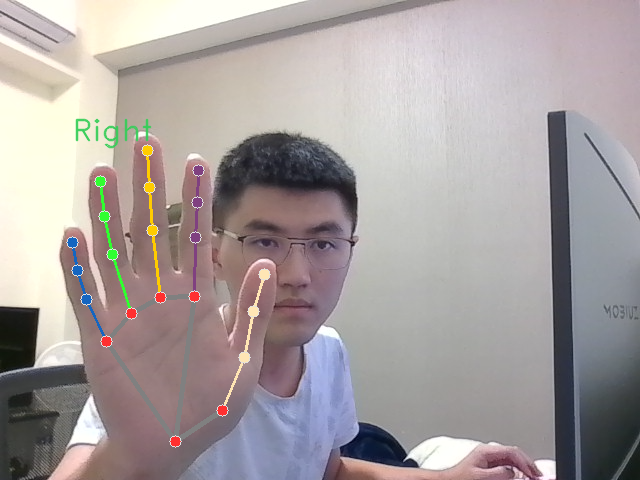

In [ ]:
import cv2
import numpy as np

import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

from IPython.display import Image, display


BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# 手掌偵測設定
options = HandLandmarkerOptions(
    num_hands=2,
    base_options=BaseOptions(model_asset_path="./models/hand_landmarker.task"),
    running_mode=VisionRunningMode.IMAGE)

# 標記文字
MARGIN = 10  # 單位是 pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # 亮綠色

# 繪製手掌骨架
def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # 遍歷各個偵測到的手掌以進行視覺化
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # 繪製手掌特徵點（hand landmarks）
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # 取得偵測到的手的邊界框的左上角
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # 在圖像上畫出慣用手（左手或右手）。
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

with HandLandmarker.create_from_options(options) as landmarker:
    cap = cv2.VideoCapture(0)                   # 讀取攝影鏡頭（webcam）
    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    while True:
        ret, frame = cap.read()
        w = frame.shape[1]                  # 畫面寬度
        h = frame.shape[0]                  # 畫面高度
        if not ret:
            print("Cannot receive frame")
            break

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        hand_landmarker_result = landmarker.detect(mp_image)

        # print(hand_landmarker_result.handedness) # 每幀影像作偵測都會打印出偵測結果

        annotated_image = draw_landmarks_on_image(frame, hand_landmarker_result)

        cv2.imshow('Live Video', annotated_image)

        key = cv2.waitKey(5) & 0xFF
        if key == ord('q'): # 按下 q 鍵停止
            break
        elif key == ord('a'):  # 按下 'a' 鍵截圖並儲存
            cv2.imwrite('hand_landmark_detection.png', annotated_image)
            print("Screenshot saved as hand_landmark_detection.png")
            display(Image(filename='hand_landmark_detection.png'))

cap.release()
cv2.destroyAllWindows()